In [1]:
import scanpy as sc
import scvi
import multigrate
import matplotlib.pyplot as plt
import gdown

In [2]:
%config InlineBackend.figure_format = 'retina'

# totalVI

## Load the dataset

In [1]:
!wget "https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=expressions.h5ad" -O hao2020-expressions.h5ad

--2021-01-05 04:46:52--  https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=expressions.h5ad
Resolving localhost (localhost)... 127.0.0.1
Connecting to localhost (localhost)|127.0.0.1|:8085... connected.
Proxy request sent, awaiting response... 200 OK
Length: 1949492332 (1.8G) [application/octet-stream]
Saving to: ‘hao2020-expressions.h5ad’

hao2020-expressions 100%[===================>]   1.82G  8.57MB/s    in 4m 16s  

2021-01-05 04:51:08 (7.26 MB/s) - ‘hao2020-expressions.h5ad’ saved [1949492332/1949492332]



In [3]:
scrna = sc.read_h5ad('hao2020-expressions.h5ad')
scrna

AnnData object with n_obs × n_vars = 161764 × 4000
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'cell_type'
    var: 'features', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors', 'neighbors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'PCs', 'SPCA'
    layers: 'count'
    obsp: 'distances'

In [6]:
!wget "https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=protein.h5ad" -O hao2020-proteins.h5ad

--2021-01-05 04:51:19--  https://hmgubox2.helmholtz-muenchen.de/index.php/s/r2W5dMJdq6mFMZY/download?path=%2Fseurat-2020&files=protein.h5ad
Resolving localhost (localhost)... 127.0.0.1
Connecting to localhost (localhost)|127.0.0.1|:8085... connected.
Proxy request sent, awaiting response... 200 OK
Length: 904554908 (863M) [application/octet-stream]
Saving to: ‘hao2020-proteins.h5ad’

hao2020-proteins.h5 100%[===================>] 862.65M  5.81MB/s    in 2m 14s  

2021-01-05 04:53:34 (6.42 MB/s) - ‘hao2020-proteins.h5ad’ saved [904554908/904554908]



In [4]:
cite = sc.read_h5ad('hao2020-proteins.h5ad')
cite

AnnData object with n_obs × n_vars = 161764 × 224
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'cell_type'
    var: 'features'
    uns: 'celltype.l1_colors', 'celltype.l2_colors', 'celltype.l3_colors'
    obsm: 'X_apca', 'X_aumap', 'X_pca', 'X_spca', 'X_umap', 'X_wnn.umap'
    varm: 'APCA'
    layers: 'count'

## Configure and train the model

In [5]:
# scvi needs one adata, so we merge rna and cite
adata = scrna
adata.obsm['proteins'] = cite.X

In [7]:
scvi.data.setup_anndata(adata, labels_key='cell_type', protein_expression_obsm_key='proteins')

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/scvi/data/_anndata.py:795: UserWarning: adata.X does not contain unnormalized count data. Are you sure this is what you want?
  logger_data_loc
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


INFO     Using protein expression from adata.obsm['proteins']                                
INFO     Generating sequential protein names                                                 
INFO     Successfully registered anndata object containing 161764 cells, 4000 vars, 1        
         batches, 8 labels, and 224 proteins. Also registered 0 extra categorical covariates 
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/scvi/data/_anndata.py:738: UserWarning: adata.obsm[proteins] does not contain unnormalized count data. Are you sure this is what you want?
  protein_expression_obsm_key


In [8]:
vae = scvi.model.TOTALVI(
    adata,
    latent_distribution="normal",
    n_layers_decoder=2
)

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered protein expression in anndata contains unnormalized count  
         data.                                                                               


In [11]:
vae.train(n_epochs=100)

INFO     Training for 100 epochs.                                                            


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/scvi/core/distributions/_negative_binomial.py:532: UserWarning: The value argument must be within the support of the distribution
  UserWarning,


INFO     KL warmup phase may exceed overall training phase.If your applications rely on      
         posterior quality, consider training for more epochs or reducing the kl warmup.     
INFO     KL warmup for 121323.0 iterations                                                   
Training...: 100%|██████████| 100/100 [37:29<00:00, 22.50s/it]
INFO     Training is still in warming up phase. If your applications rely on the posterior   
         quality, consider training for more epochs or reducing the kl warmup.               
INFO     Training time:  2123 s. / 100 epochs                                                


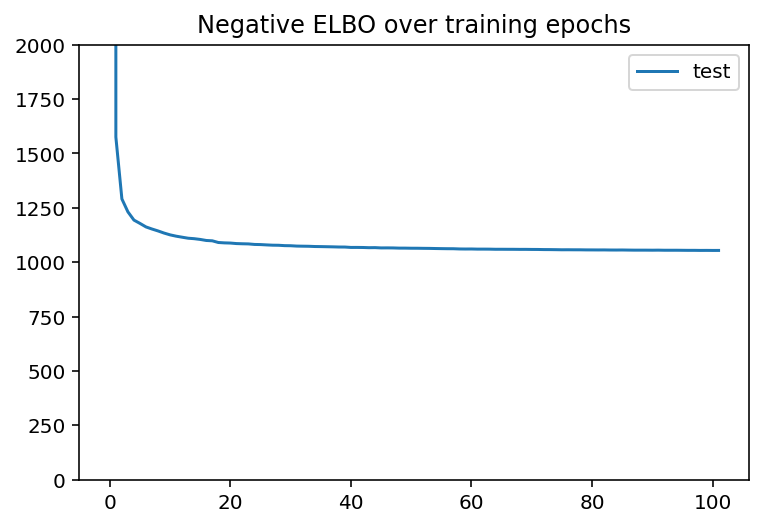

In [12]:
plt.plot(vae.trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(0, 2000)
plt.legend()

In [28]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

WARNING  Make sure the registered X field in anndata contains unnormalized count data.       
WARNING  Make sure the registered protein expression in anndata contains unnormalized count  
         data.                                                                               


In [30]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata)

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


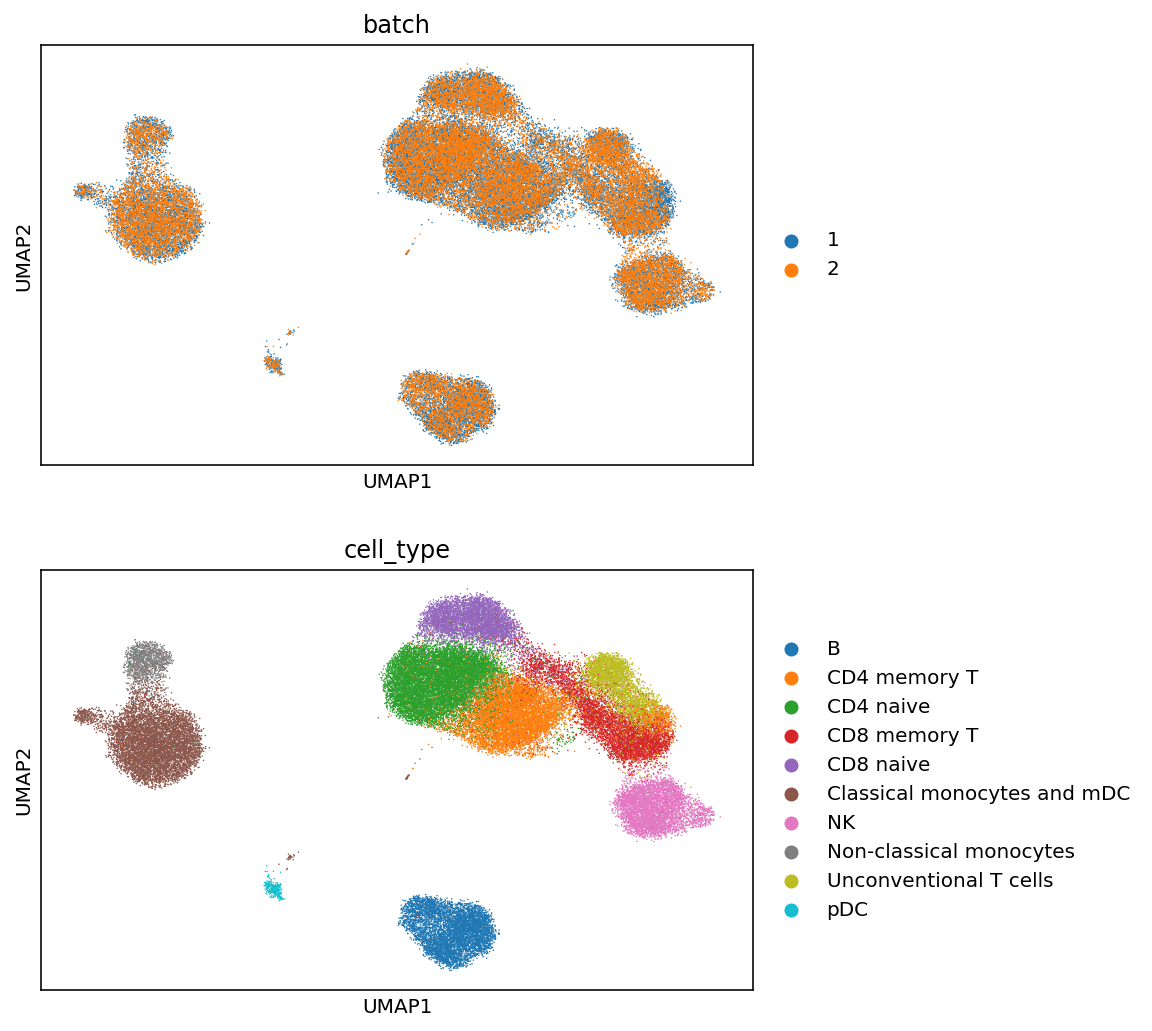

In [32]:
sc.pl.umap(adata, color=['batch', 'cell_type'], ncols=1)

In [34]:
sc.pp.pca(adata)
multigrate.metrics.metrics(
    adata, adata,
    batch_key='batch',
    label_key='cell_type',
    method='totalVI'
)

/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Clustering...
ASW label/batch...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_catego

PCR batch...
Graph connectivity...
ASW label...


/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/aomidi/.conda/envs/seurat/lib/python3.7/site-packages/multigrate-0.1.0-py3.7.egg/multigrate/metrics.py:548: FutureWarning: This location for 'connectivities' is deprecated. It has been moved to .obsp[connectivities], and will not be accesible here in a future version of anndata.
  _,labs = connected_components(adata_post_sub.uns['neighbors']['connectivities'], connection='strong')


NMI cluster/label...
ARI cluster/label...
Isolated label silhouette...


,score
ASW_label/batch,0.980036
PCR_batch,0.000000
graph_conn,0.994866
ASW_label,0.548290
NMI_cluster/label,0.829839
ARI_cluster/label,0.801511
isolated_label_silhouette,0.544825
